# Evaluation Model with real data

## Prepare Data

In [7]:
library(readxl)

library(xts)

library(dplyr)

data <- read_excel("/kaggle/input/tain-data/US_PCE_training.xlsx")

##处理数据
data <- na.omit(data)

# 转化成长数据
data_transposed <- t(data)

# 将转置的矩阵转换为数据框
data_transposed <- as.data.frame(data_transposed)

# 设置新的列名
colnames(data_transposed) <- data_transposed[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
data_transposed <- data_transposed[-1, ]
# 重新排序列，使第二列成为第一列
data_transposed <- data_transposed[c(2, 1, 3:ncol(data_transposed))]

# 转换所有列为数值类型
data_transposed[] <- lapply(data_transposed, function(x) as.numeric(as.character(x)))


Newdata <- data_transposed


Newdata <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~ (log(.) - log(lag(.))) * 12,
    .names = "{.col}_log_diff_12"
  ))

#将inflation rate移动数据第一列
# 假设 data_transformed 是包含我们之前计算得到的列的数据框
# 首先重命名列
Newdata <- Newdata %>%
  rename('inflation rate' = 'Personal consumption expenditures_log_diff_12')

# 然后将重命名的列移动到第一列位置
Newdata <- Newdata %>%
  relocate(`inflation rate`, .before = 1)


#为每列变量生成24月的滞后项
# 首先生成滞后变量并添加到临时数据框中
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = list(lag1 = ~lag(., 1), lag2 = ~lag(., 2), lag3 = ~lag(., 3),
                lag4 = ~lag(., 4), lag5 = ~lag(., 5), lag6 = ~lag(., 6),
                lag7 = ~lag(., 7), lag8 = ~lag(., 8), lag9 = ~lag(., 9),
                lag10 = ~lag(., 10), lag11 = ~lag(., 11), lag12 = ~lag(., 12),
                lag13 = ~lag(., 13), lag14 = ~lag(., 14), lag15 = ~lag(., 15),
                lag16 = ~lag(., 16), lag17 = ~lag(., 17), lag18 = ~lag(., 18),
                lag19 = ~lag(., 19), lag20 = ~lag(., 20), lag21 = ~lag(., 21),
                lag22 = ~lag(., 22), lag23 = ~lag(., 23), lag24 = ~lag(., 24)),
    .names = "{.col}_{.fn}"
  ))

# 从临时数据框中选择所有生成的滞后变量列，创建一个新的数据框
data_transposed_lag <- temp_data %>%
  select(matches("lag(1[0-9]|2[0-4]|[1-9])$"))



#创建前三个月的平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后一个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3 <- temp_data %>%
  select(ends_with("_rollmean3"))

#创建前六个月的平均值
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6 <- temp_data %>%
  select(ends_with("_rollmean6"))




#创建前12个月的平均值
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12 <- temp_data %>%
  select(ends_with("_rollmean12"))


#创建前24个月的平均值
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24 <- temp_data %>%
  select(ends_with("_rollmean24"))



#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined <- bind_cols(Newdata, data_rollmean3, data_rollmean6, 
                               data_rollmean12, data_rollmean24, data_transposed_lag)

all_data_combined <- all_data_combined %>%
  select(-c(3:411))


all_data_combined <- na.omit(all_data_combined)

#标准化X
X <- all_data_combined[,-(1:2)]

X_scaled <- scale(X)

Y <- all_data_combined[,1]

X_scaled <- as.matrix(X_scaled)

In [8]:
# 拟合LASSO回归模型2
# 利用信息到提前3月，前24个月的数据预测

# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_3months  <- data_transposed_lag %>%
  select(-matches(".*_lag[12]$"))

#3个月平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_3months <- temp_data %>%
  select(ends_with("_rollmean3"))

##创建前六个月的平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_3months  <- temp_data %>%
  select(ends_with("_rollmean6"))

#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_3months  <- temp_data %>%
  select(ends_with("_rollmean12"))

#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_3months  <- temp_data %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_3months <- bind_cols(Newdata, data_rollmean3_3months, data_rollmean6_3months, 
                               data_rollmean12_3months, data_rollmean24_3months, data_transposed_lag_3months)

all_data_combined_3months <- all_data_combined_3months %>%
  select(-c(3:411))


all_data_combined_3months  <- na.omit(all_data_combined_3months )

#标准化X
X_3months <- all_data_combined_3months[,-(1:2)]

X_scaled_3months <- scale(X_3months)

Y_3months <- all_data_combined_3months[,1]

X_scaled_3months <- as.matrix(X_scaled_3months)


In [9]:
### 拟合LASSO回归模型3
# 利用信息到提前12月，前24个月的数据预测
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_12months  <- data_transposed_lag %>%
  select(-matches(".*_lag(1[01]|[1-9])$"))


#3个月平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后12个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后12个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_12months <- temp_data %>%
  select(ends_with("_rollmean3"))

##创建前六个月的平均值


# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean6_12months  = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_12months   <- temp_data %>%
  select(ends_with("_rollmean6"))

#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean12_12months  = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_12months   <- temp_data %>%
  select(ends_with("_rollmean12"))

#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean24_12months  = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_12months  <- temp_data %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_12months  <- bind_cols(Newdata, data_rollmean3_12months , data_rollmean6_12months , 
                                       data_rollmean12_12months , data_rollmean24_12months , data_transposed_lag_12months )

all_data_combined_12months  <- all_data_combined_12months  %>%
  select(-c(3:411))


all_data_combined_12months   <- na.omit(all_data_combined_12months  )

#标准化X
X_12months  <- all_data_combined_12months [,-(1:2)]

X_scaled_12months  <- scale(X_12months )

Y_12months  <- all_data_combined_12months [,1]

X_scaled_12months  <- as.matrix(X_scaled_12months )

In [11]:
#Test 数据处理V2
# 加载数据
testing_data <- read_excel("/kaggle/input/real-data/US_PCE_testing_real.xlsx")

##处理数据
testing_data <- na.omit(testing_data)

# 转化成长数据
testing_data <- t(testing_data)

# 将转置的矩阵转换为数据框
testing_data <- as.data.frame(testing_data)

# 设置新的列名
colnames(testing_data) <- testing_data[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
testing_data <- testing_data[-1, ]
# 重新排序列，使第二列成为第一列
testing_data <- testing_data[c(2, 1, 3:ncol(testing_data))]

# 转换所有列为数值类型
testing_data[] <- lapply(testing_data, function(x) as.numeric(as.character(x)))

data_transposed_test <- rbind(data_transposed, testing_data)

Newdata_test <- data_transposed_test

Newdata_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~ (log(.) - log(lag(.))) * 12,
    .names = "{.col}_log_diff_12"
  ))

Newdata_test <- Newdata_test %>%
  rename('inflation rate' = 'Personal consumption expenditures_log_diff_12')

# 然后将重命名的列移动到第一列位置
Newdata_test <- Newdata_test %>%
  relocate(`inflation rate`, .before = 1)

#为每列变量生成24月的滞后项
# 首先生成滞后变量并添加到临时数据框中
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = list(lag1 = ~lag(., 1), lag2 = ~lag(., 2), lag3 = ~lag(., 3),
                lag4 = ~lag(., 4), lag5 = ~lag(., 5), lag6 = ~lag(., 6),
                lag7 = ~lag(., 7), lag8 = ~lag(., 8), lag9 = ~lag(., 9),
                lag10 = ~lag(., 10), lag11 = ~lag(., 11), lag12 = ~lag(., 12),
                lag13 = ~lag(., 13), lag14 = ~lag(., 14), lag15 = ~lag(., 15),
                lag16 = ~lag(., 16), lag17 = ~lag(., 17), lag18 = ~lag(., 18),
                lag19 = ~lag(., 19), lag20 = ~lag(., 20), lag21 = ~lag(., 21),
                lag22 = ~lag(., 22), lag23 = ~lag(., 23), lag24 = ~lag(., 24)),
    .names = "{.col}_{.fn}"
  ))

# 从临时数据框中选择所有生成的滞后变量列，创建一个新的数据框
data_transposed_lag_test <- temp_data_test %>%
  select(matches("lag(1[0-9]|2[0-4]|[1-9])$"))



#创建前三个月的平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后一个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_test <- temp_data_test %>%
  select(ends_with("_rollmean3"))



#创建前六个月的平均值
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_test <- temp_data_test %>%
  select(ends_with("_rollmean6"))


#创建前12个月的平均值
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_test <- temp_data_test %>%
  select(ends_with("_rollmean12"))



#创建前24个月的平均值
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_test <- temp_data_test %>%
  select(ends_with("_rollmean24"))


#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_test <- bind_cols(Newdata_test, data_rollmean3_test, data_rollmean6_test, 
                               data_rollmean12_test, data_rollmean24_test, data_transposed_lag_test)

all_data_combined_test <- all_data_combined_test %>%
  select(-c(3:411))


all_data_combined_test <- na.omit(all_data_combined_test)

#标准化X
X_test <- all_data_combined_test[,-(1:2)]

X_scaled_test <- scale(X_test)

Y_test <- all_data_combined_test[,1]

X_scaled_test <- as.matrix(X_scaled_test)




### 数据整理2
# 利用信息到提前3月，前24个月的数据预测
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_3months_test  <- data_transposed_lag_test %>%
  select(-matches(".*_lag[12]$"))

# 创建临时数据框，先将所有变量延后三个月
temp_data_test  <- Newdata_test  %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_3months_test  <- temp_data_test  %>%
  select(ends_with("_rollmean3"))



# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_3months_test  <- temp_data_test %>%
  select(ends_with("_rollmean6"))

#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_3months_test  <- temp_data_test %>%
  select(ends_with("_rollmean12"))

#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_3months_test  <- temp_data_test %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_3months_test  <- bind_cols(Newdata_test , data_rollmean3_3months_test , data_rollmean6_3months_test , 
                                       data_rollmean12_3months_test , data_rollmean24_3months_test , data_transposed_lag_3months_test )

all_data_combined_3months_test  <- all_data_combined_3months_test  %>%
  select(-c(3:411))


all_data_combined_3months_test   <- na.omit(all_data_combined_3months_test  )

#标准化X
X_3months_test  <- all_data_combined_3months_test [,-(1:2)]

X_scaled_3months_test  <- scale(X_3months_test )

Y_3months_test  <- all_data_combined_3months_test [,1]

X_scaled_3months_test  <- as.matrix(X_scaled_3months_test )

### 拟合LASSO回归模型3
# 利用信息到提前12月，前24个月的数据预测
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_12months_test   <- data_transposed_lag_test  %>%
  select(-matches(".*_lag(1[01]|[1-9])$"))

# 创建临时数据框，先将所有变量延后12个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后12个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_12months_test <- temp_data_test %>%
  select(ends_with("_rollmean3"))


# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean6_12months  = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_12months_test   <- temp_data_test %>%
  select(ends_with("_rollmean6"))


#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean12_12months  = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_12months_test   <- temp_data_test %>%
  select(ends_with("_rollmean12"))




#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean24_12months  = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_12months_test  <- temp_data_test %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_12months_test  <- bind_cols(Newdata_test, data_rollmean3_12months_test , data_rollmean6_12months_test , 
                                         data_rollmean12_12months_test , data_rollmean24_12months_test , data_transposed_lag_12months_test )

all_data_combined_12months_test  <- all_data_combined_12months_test  %>%
  select(-c(3:411))


all_data_combined_12months_test   <- na.omit(all_data_combined_12months_test  )

#标准化X
X_12months_test  <- all_data_combined_12months_test [,-(1:2)]

X_scaled_12months_test  <- scale(X_12months_test )

Y_12months_test  <- all_data_combined_12months_test [,1]

X_scaled_12months_test  <- as.matrix(X_scaled_12months_test )


## AR（1）

In [35]:
#处理数据
data <- read_excel("/kaggle/input/tain-data/US_PCE_training.xlsx")

##处理数据
data <- na.omit(data)

# 转化成长数据
data_transposed <- t(data)

# 将转置的矩阵转换为数据框
data_transposed <- as.data.frame(data_transposed)

# 设置新的列名
colnames(data_transposed) <- data_transposed[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
data_transposed <- data_transposed[-1, ]
# 重新排序列，使第二列成为第一列
data_transposed <- data_transposed[c(2, 1, 3:ncol(data_transposed))]

# 转换所有列为数值类型
data_transposed[] <- lapply(data_transposed, function(x) as.numeric(as.character(x)))



data_transposed$inflation_rate <- (log(data_transposed$`Personal consumption expenditures`) -
                              log(lag(data_transposed$`Personal consumption expenditures`))) * 12

inflation_ts <- ts(data_transposed$inflation_rate, frequency = 12)  # Assuming monthly data with annual frequency

inflation_ts <- na.omit(inflation_ts)
# 一阶差分
diff_inflation_ts <- diff(inflation_ts, differences = 1)


diff_inflation_ts <- na.omit(diff_inflation_ts)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



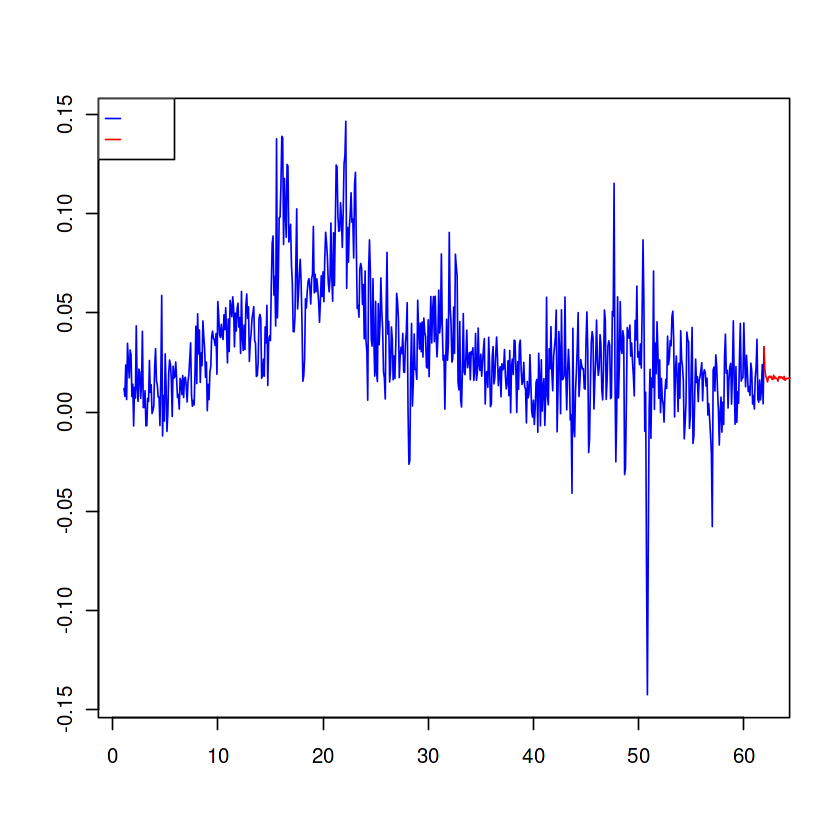

In [36]:
# 拟合ARIMA模型
library(forecast)
model_arima <- auto.arima(diff_inflation_ts)

# 预测未来50个月
forecast_diff <- forecast(model_arima, h=50)

# 逆向差分
last_original_value <- tail(inflation_ts, n=1)  # 取原始序列的最后一个值

# 初始化预测结果数组，长度等于预测月份+1，第一个元素为最后一个实际值
forecast_original <- numeric(length = length(forecast_diff$mean) + 1)
forecast_original[1] <- last_original_value

# 通过逐步累加预测的差分恢复原始尺度的预测值
for (i in 2:length(forecast_original)) {
  forecast_original[i] <- forecast_original[i - 1] + forecast_diff$mean[i - 1]
}

# 绘图
time_original <- time(inflation_ts)
time_forecast <- seq(max(time_original), by = 1/12, length.out = length(forecast_original))

# 绘制图像
plot(time_original, inflation_ts, type = 'l', col = 'blue', xlab = '时间', ylab = '通胀率', main = '通胀率及其预测')
lines(time_forecast, forecast_original, col = 'red')
legend("topleft", legend = c("原始通胀率", "预测通胀率"), col = c("blue", "red"), lty = 1, cex = 0.8)


[1] "MSE： 0.00134628663460013"


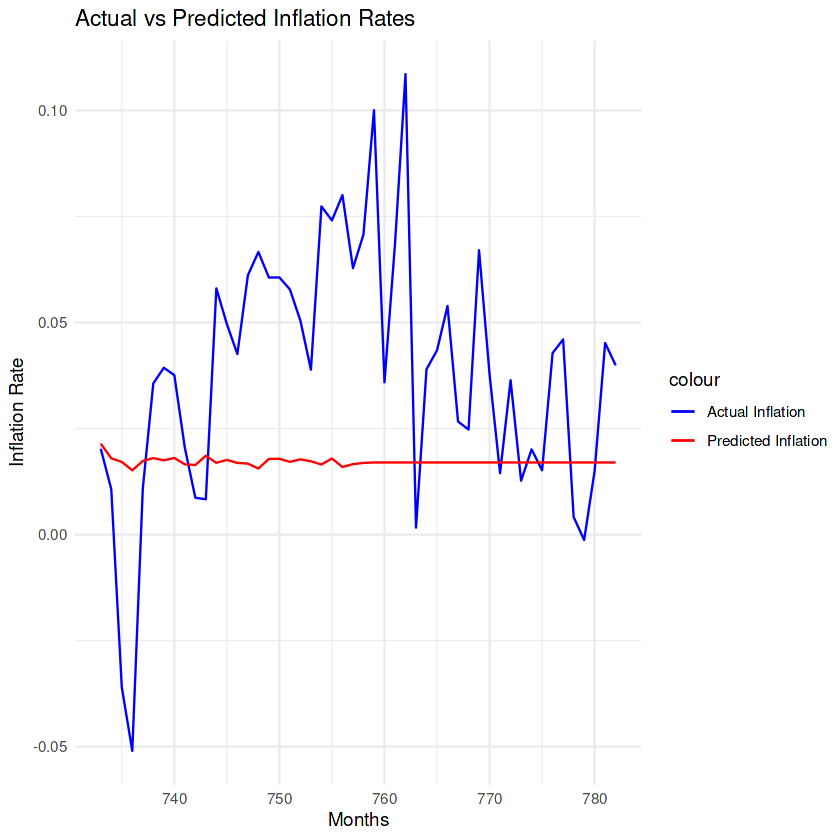

In [37]:
#比较AR（1）模型

testing_data <- read_excel("/kaggle/input/real-data/US_PCE_testing_real.xlsx")
##处理数据
testing_data <- na.omit(testing_data)

# 转化成长数据
testing_data <- t(testing_data)

# 将转置的矩阵转换为数据框
testing_data <- as.data.frame(testing_data)

# 设置新的列名
colnames(testing_data) <- testing_data[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
testing_data <- testing_data[-1, ]
# 重新排序列，使第二列成为第一列
testing_data <- testing_data[c(2, 1, 3:ncol(testing_data))]

# 转换所有列为数值类型
testing_data[] <- lapply(testing_data, function(x) as.numeric(as.character(x)))

data_transposed <- data_transposed[,-207]
data_transposed_test <- rbind(data_transposed, testing_data)

data_transposed_test$inflation_rate <- (log(data_transposed_test$`Personal consumption expenditures`) -
                                     log(lag(data_transposed_test$`Personal consumption expenditures`))) * 12

# 提取Y_test的后50行作为新的目标数据

Future_data<- data_transposed_test[(nrow(data_transposed_test)-49):nrow(data_transposed_test),]
# 保留Future_data的第一列和最后一列
Future_data<- Future_data[, c(1, ncol(Future_data))]


# 使用预测的时间和对应的预测值创建数据框
forecast_df <- data.frame(
  Time = time_forecast,
  Predicted_Inflation_Rate = forecast_original
)
# 删除forecast_df的第一行
forecast_df <- forecast_df[-1, ]
# 重命名列
names(forecast_df)[names(forecast_df) == "Time"] <- "month"
# 设置第一行的值为733，后续递增
forecast_df$month <- 733 + (0:(nrow(forecast_df) - 1))

# 假设 Future_data 中的时间列也命名为 'months'，并且有一个名为 'Actual_Inflation' 的列
# 合并数据框
combined_data <- merge(forecast_df, Future_data, by = "month", all = TRUE)

# 重命名列以区分预测和实际值

names(combined_data)[names(combined_data) == "inflation_rate"] <- "Actual_Inflation_Rate"

library(ggplot2)

# 绘制图形
ggplot(data = combined_data, aes(x = month)) +
  geom_line(aes(y = Actual_Inflation_Rate, colour = "Actual Inflation")) +
  geom_line(aes(y = Predicted_Inflation_Rate, colour = "Predicted Inflation")) +
  scale_colour_manual(values = c("Actual Inflation" = "blue", "Predicted Inflation" = "red")) +
  labs(title = "Actual vs Predicted Inflation Rates", x = "Months", y = "Inflation Rate") +
  theme_minimal()

mse_AR <- mean((combined_data$Actual_Inflation_Rate -  combined_data$Predicted_Inflation_Rate)^2)
print(paste("MSE：", mse_AR))


## Lasso

### Lasso(1 month ahead)

In [29]:
###进行lasso回归

# 安装和加载glmnet包
if (!require(glmnet)) {
  install.packages("glmnet", dependencies = TRUE)
  library(glmnet)
}

# 假设Y已经存在于你的环境中，并且与X_scaled的行数相同
# 拟合LASSO回归模型1
# 利用信息到提前1月，前24个月的数据预测
set.seed(123)
lasso_model <- glmnet(X_scaled, Y, family = "gaussian", alpha = 1)



# 进行交叉验证
cv_lasso <- cv.glmnet(X_scaled, Y, family = "gaussian", alpha = 1)


# 最佳lambda
best_lambda <- cv_lasso$lambda.min
# 使用最佳lambda重新拟合模型
best_lasso_model <- glmnet(X_scaled, Y, family = "gaussian", alpha = 1, lambda = best_lambda)


# 获取模型系数
coefficients_best <- coef(best_lasso_model, s = "lambda.min")

# 计算非零系数的数量
non_zero_coeffs_count <- sum(coefficients_best != 0)

# 打印非零系数的数量
print(non_zero_coeffs_count)




[1] 233


[1] "均方误差为: 0.000680915033858168"


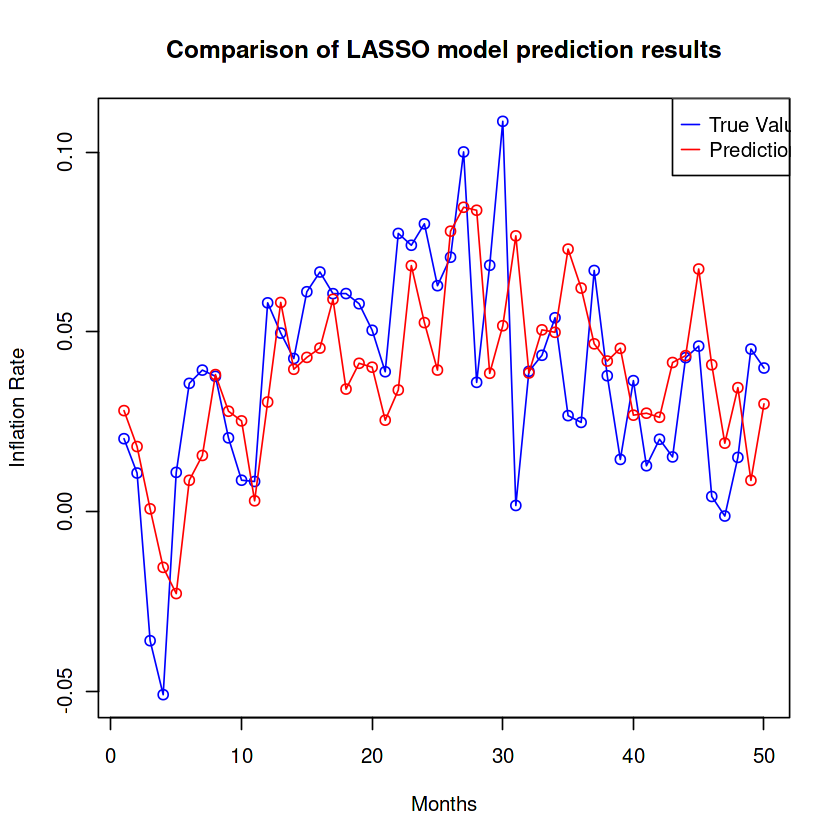

In [30]:
#在新数据中验证lasso
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优模型进行预测
predictions <- predict(best_lasso_model, s = best_lambda, newx = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse <- mean((Y_test_sub - predictions)^2)
print(paste("均方误差为:", mse))


### Lasso(3 months ahead)

In [31]:
# 利用信息到提前3月，前24个月的数据预测
set.seed(123)
lasso_model_3months <- glmnet(X_scaled_3months, Y_3months, family = "gaussian", alpha = 1)



# 进行交叉验证
cv_lasso_3months <- cv.glmnet(X_scaled_3months, Y_3months, family = "gaussian", alpha = 1)


# 最佳lambda
best_lambda_3months <- cv_lasso_3months$lambda.min
# 使用最佳lambda重新拟合模型
best_lasso_model_3months <- glmnet(X_scaled_3months, Y_3months, family = "gaussian", alpha = 1, lambda = best_lambda_3months)



# 获取模型系数
coefficients_best_3months <- coef(best_lasso_model_3months, s = "lambda.min")

# 计算非零系数的数量
non_zero_coeffs_count_3months <- sum(coefficients_best_3months != 0)

# 打印非零系数的数量
print(non_zero_coeffs_count_3months)



[1] 113


[1] "均方误差为: 0.000873233004025725"


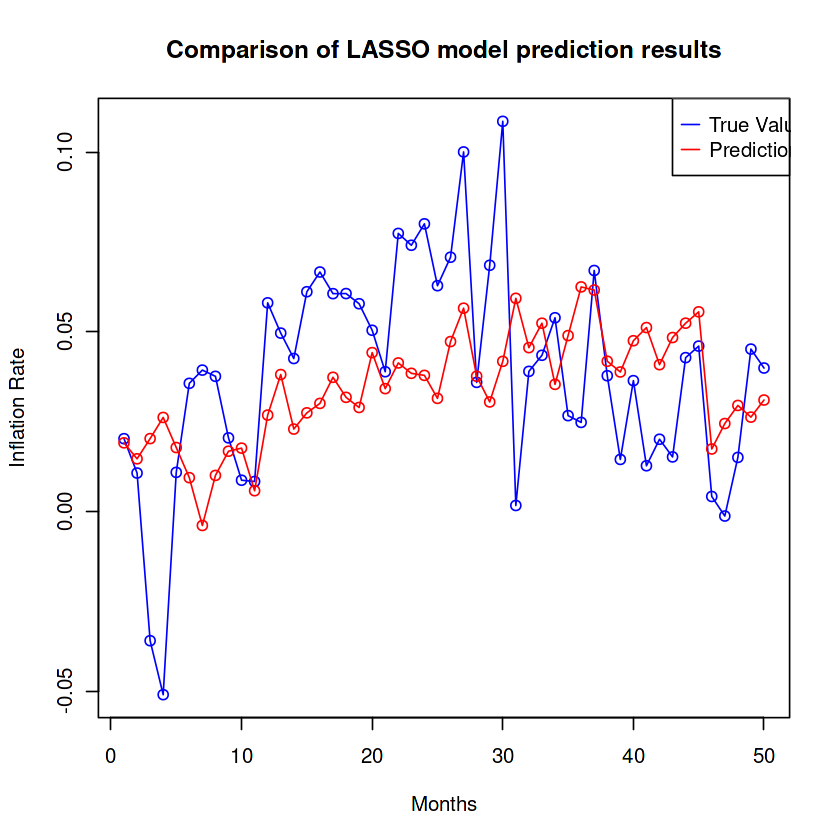

In [32]:
#在新数据中验证lasso，提前三个月
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub_3months <- X_scaled_3months_test[(nrow(X_scaled_3months_test)-49):nrow(X_scaled_3months_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub_3months <- Y_3months_test[(length(Y_3months_test)-49):length(Y_3months_test)]

# 使用最优模型进行预测
predictions_3months <- predict(best_lasso_model_3months, s = best_lambda_3months, newx = X_test_sub_3months)

# 可视化实际值与预测值
plot(Y_test_sub_3months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions_3months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse_3months <- mean((Y_test_sub_3months - predictions_3months)^2)
print(paste("均方误差为:", mse_3months))


### Lasso(1 year ahead)

In [33]:
# 利用信息到提前12月，前24个月的数据预测
set.seed(123)
lasso_model_12months  <- glmnet(X_scaled_12months , Y_12months , family = "gaussian", alpha = 1)



# 进行交叉验证
cv_lasso_12months  <- cv.glmnet(X_scaled_12months , Y_12months , family = "gaussian", alpha = 1)

# 最佳lambda
best_lambda_12months  <- cv_lasso_12months $lambda.min
# 使用最佳lambda重新拟合模型
best_lasso_model_12months  <- glmnet(X_scaled_12months , Y_12months , family = "gaussian", alpha = 1, lambda = best_lambda_12months )


# 获取模型系数
coefficients_best_12months  <- coef(best_lasso_model_12months , s = "lambda.min")

# 计算非零系数的数量
non_zero_coeffs_count_12months <- sum(coefficients_best_12months != 0)

# 打印非零系数的数量
print(non_zero_coeffs_count_12months )


[1] 88


[1] "均方误差为: 0.00157663073403735"


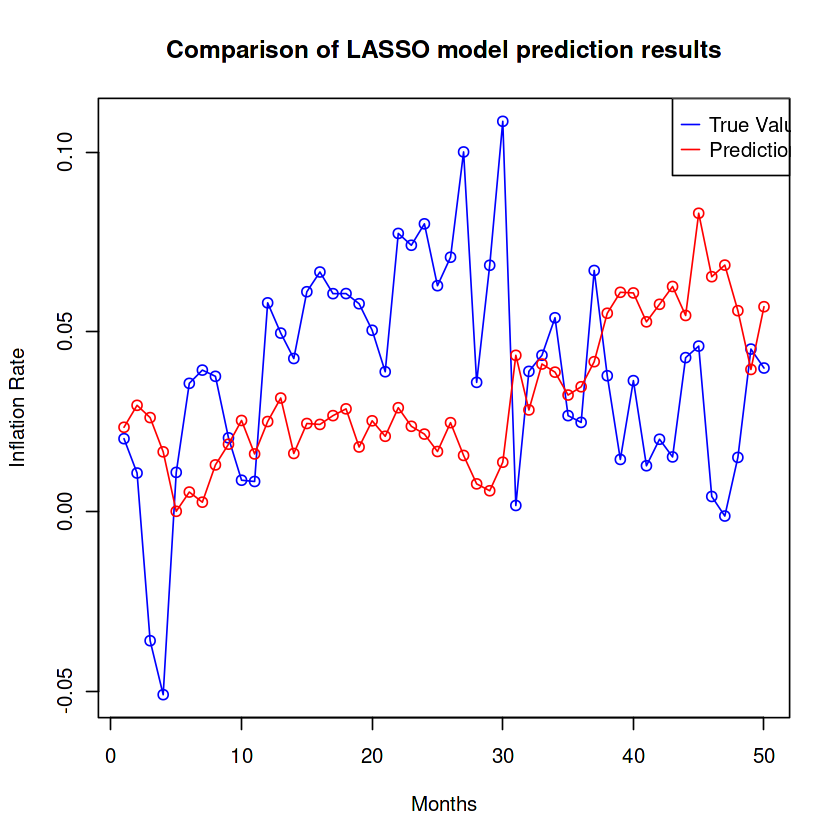

In [34]:
#在新数据中验证lasso，提前12个月
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub_12months <- X_scaled_12months_test[(nrow(X_scaled_12months_test)-49):nrow(X_scaled_12months_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub_12months <- Y_12months_test[(length(Y_12months_test)-49):length(Y_12months_test)]

# 使用最优模型进行预测
predictions_12months <- predict(best_lasso_model_12months, s = best_lambda_12months, newx = X_test_sub_12months)

# 可视化实际值与预测值
plot(Y_test_sub_12months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions_12months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse_12months <- mean((Y_test_sub_12months - predictions_12months)^2)
print(paste("均方误差为:", mse_12months))

## Random Forest(1 month ahead)

In [21]:
# 加载LASSO模型
rf_tuned_model <- readRDS("/kaggle/input/rf-model/rf_tuned_model.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'rf_tuned_model.rds'.\n")


LASSO model loaded successfully from 'rf_tuned_model.rds'.


[1] "均方误差为: 0.00101843012035135"


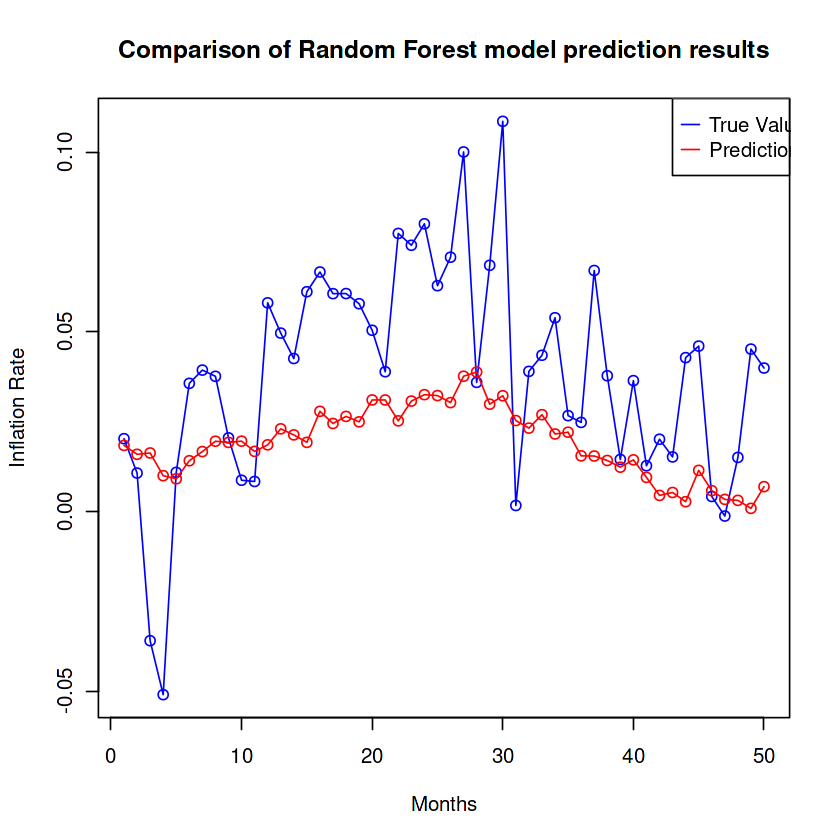

In [22]:
# 在新数据中验证随机森林模型
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优随机森林模型进行预测
predictions_rf <- predict(rf_tuned_model, newdata = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of Random Forest model prediction results")
lines(predictions_rf, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse <- mean((Y_test_sub - predictions_rf)^2)
print(paste("均方误差为:", mse))


## Random Forest(3 months ahead)

In [23]:
# 加载LASSO模型
rf_tuned_model_3months <- readRDS("/kaggle/input/rf-model-3/rf_tuned_model_3months.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'rf_tuned_model_3months.rds'.\n")

LASSO model loaded successfully from 'rf_tuned_model_3months.rds'.


[1] "均方误差为: 0.00153356273185573"


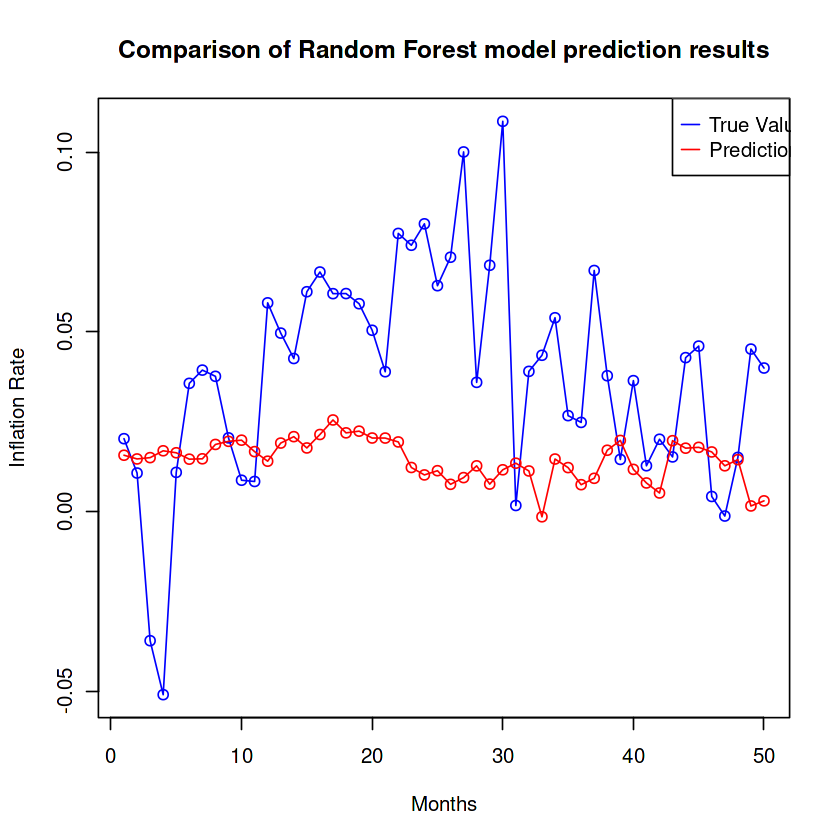

In [24]:
# 在新数据中验证随机森林模型，提前三个月
# 提取X_scaled_3months_test的后50行作为新的测试数据
X_test_sub_3months <- X_scaled_3months_test[(nrow(X_scaled_3months_test)-49):nrow(X_scaled_3months_test), ]

# 提取Y_3months_test的后50行作为新的目标数据
Y_test_sub_3months <- Y_3months_test[(length(Y_3months_test)-49):length(Y_3months_test)]

# 使用最优随机森林模型进行预测
predictions_3months <- predict(rf_tuned_model_3months, newdata = X_test_sub_3months)

# 可视化实际值与预测值
plot(Y_test_sub_3months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of Random Forest model prediction results")
lines(predictions_3months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_3months <- mean((Y_test_sub_3months - predictions_3months)^2)
print(paste("均方误差为:", mse_3months))



## Random Forest(1 year ahead)

In [25]:
# 加载LASSO模型
rf_tuned_model_12months <- readRDS("/kaggle/input/rf-model-12/rf_tuned_model_12months.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'rf_tuned_model_12months.rds'.\n")

LASSO model loaded successfully from 'rf_tuned_model_12months.rds'.


[1] "均方误差为: 0.00125324171892037"


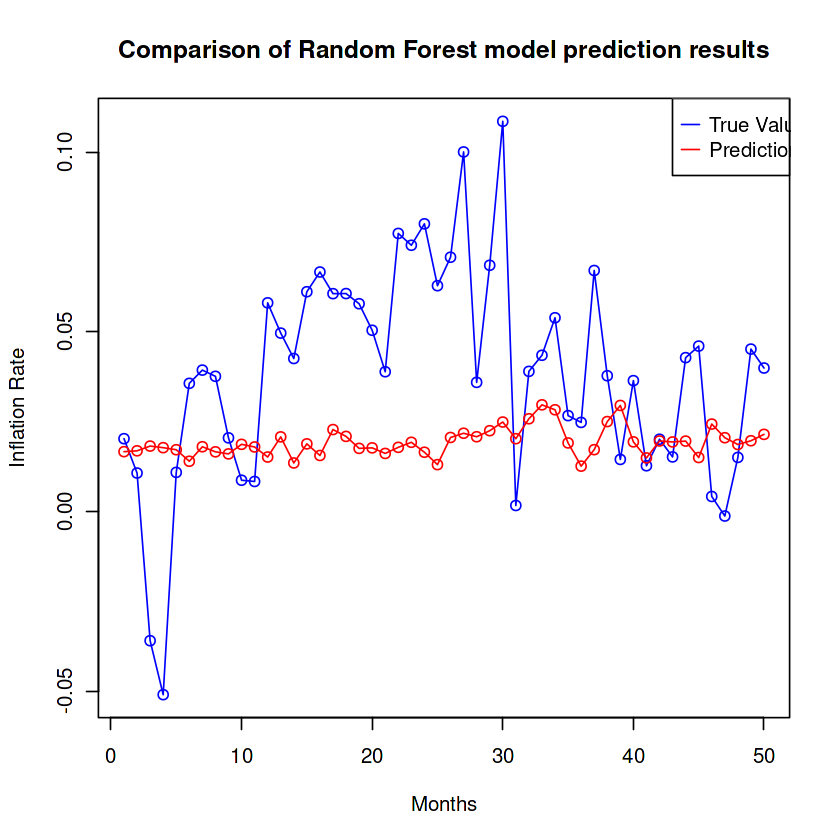

In [26]:
# 在新数据中验证随机森林模型，提前12个月
# 提取X_scaled_12months_test的后50行作为新的测试数据
X_test_sub_12months <- X_scaled_12months_test[(nrow(X_scaled_12months_test)-49):nrow(X_scaled_12months_test), ]

# 提取Y_12months_test的后50行作为新的目标数据
Y_test_sub_12months <- Y_12months_test[(length(Y_12months_test)-49):length(Y_12months_test)]

# 使用最优随机森林模型进行预测
predictions_12months <- predict(rf_tuned_model_12months, newdata = X_test_sub_12months)

# 可视化实际值与预测值
plot(Y_test_sub_12months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of Random Forest model prediction results")
lines(predictions_12months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_12months <- mean((Y_test_sub_12months - predictions_12months)^2)
print(paste("均方误差为:", mse_12months))





## GBM(1 month ahead)

In [15]:


# 加载模型
gbm_model <- readRDS("/kaggle/input/gbm-model/gbm_model.rds")


# 打印加载成功的消息
cat("Model loaded successfully from 'gbm_model.rds'.\n")


Model loaded successfully from 'gbm_model.rds'.


[1] "均方误差为: 0.000780838395468866"


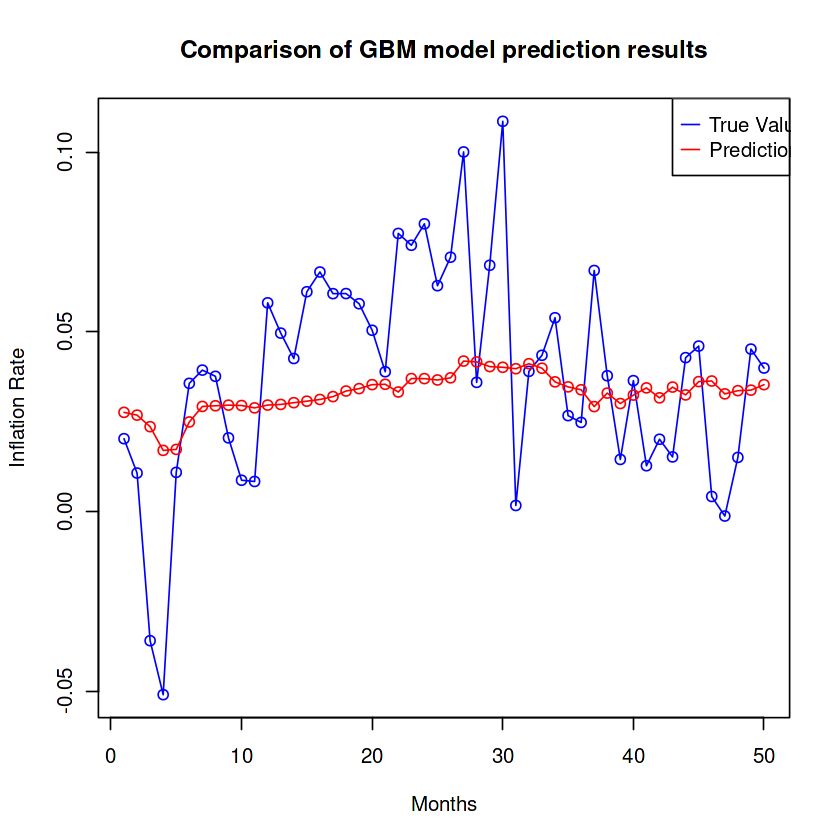

In [16]:
# 在新数据中验证GBM模型
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优GBM模型进行预测
predictions_gbm <- predict(gbm_model, newdata = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of GBM model prediction results")
lines(predictions_gbm, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse <- mean((Y_test_sub - predictions_gbm)^2)
print(paste("均方误差为:", mse))


## GBM(3 months ahead)

In [17]:
# 加载模型
gbm_model_3months <- readRDS("/kaggle/input/gbm-model-3/gbm_model_3months.rds")

# 打印加载成功的消息
cat("Model loaded successfully from 'gbm_model_3months.rds'.\n")


Model loaded successfully from 'gbm_model_3months.rds'.


[1] "均方误差为: 0.000934570881948413"


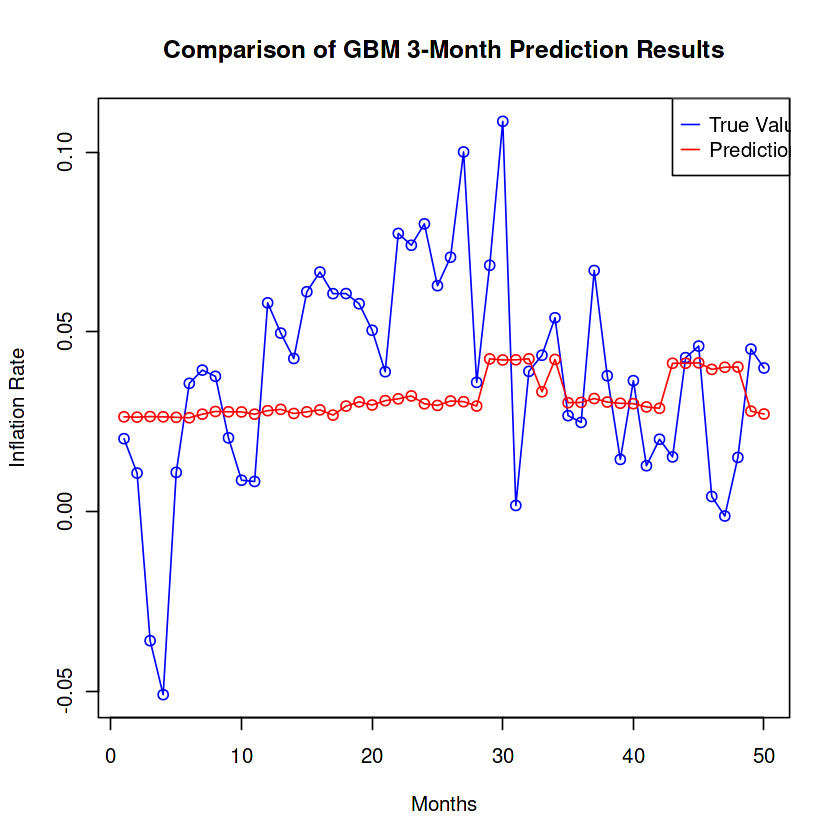

In [18]:
# 在新数据中验证GBM模型，预测未来3个月
# 提取X_scaled_3months_test的后50行作为新的测试数据
X_test_sub_3months <- X_scaled_3months_test[(nrow(X_scaled_3months_test)-49):nrow(X_scaled_3months_test), ]

# 提取Y_3months_test的后50行作为新的目标数据
Y_test_sub_3months <- Y_3months_test[(length(Y_3months_test)-49):length(Y_3months_test)]

# 使用最优GBM模型进行预测
predictions_3months_gbm <- predict(gbm_model_3months, newdata = X_test_sub_3months)

# 可视化实际值与预测值
plot(Y_test_sub_3months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of GBM 3-Month Prediction Results")
lines(predictions_3months_gbm, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_3months_gbm <- mean((Y_test_sub_3months - predictions_3months_gbm)^2)
print(paste("均方误差为:", mse_3months_gbm))


## GBM(1 year ahead)

In [19]:
# 加载模型
gbm_model_12months <- readRDS("/kaggle/input/gbm-model-12/gbm_model_12months.rds")

# 打印加载成功的消息
cat("Model loaded successfully from 'gbm_model_12months.rds'.\n")


Model loaded successfully from 'gbm_model_12months.rds'.


[1] "均方误差为: 0.000996639325754001"


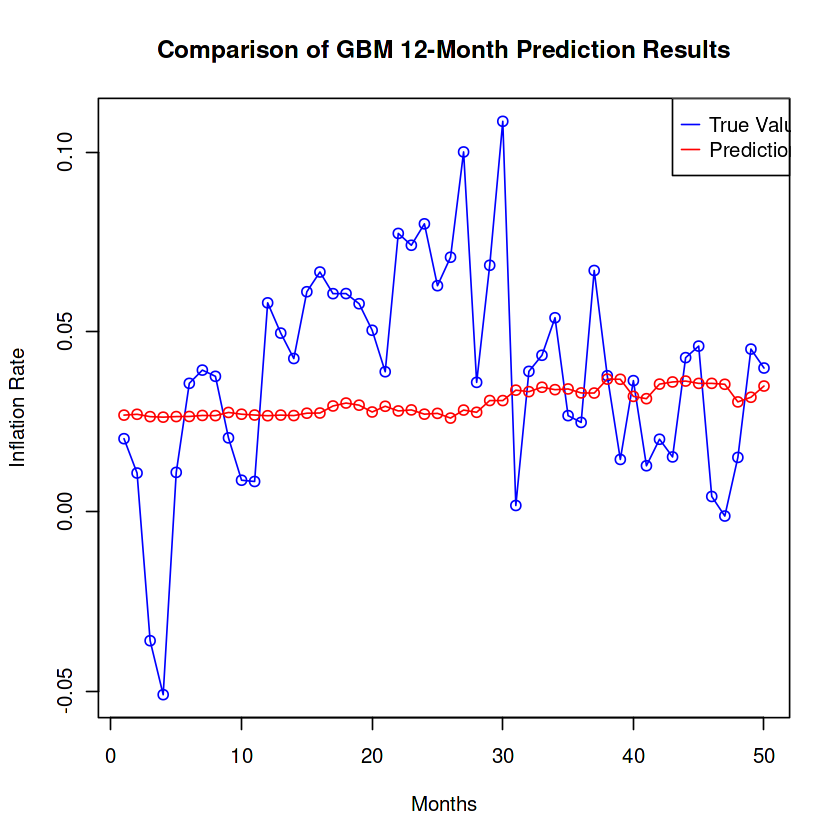

In [20]:
# 在新数据中验证GBM模型，预测未来12个月
# 提取X_scaled_12months_test的后50行作为新的测试数据
X_test_sub_12months <- X_scaled_12months_test[(nrow(X_scaled_12months_test)-49):nrow(X_scaled_12months_test), ]

# 提取Y_12months_test的后50行作为新的目标数据
Y_test_sub_12months <- Y_12months_test[(length(Y_12months_test)-49):length(Y_12months_test)]

# 使用最优GBM模型进行预测
predictions_12months_gbm <- predict(gbm_model_12months, newdata = X_test_sub_12months)

# 可视化实际值与预测值
plot(Y_test_sub_12months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of GBM 12-Month Prediction Results")
lines(predictions_12months_gbm, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_12months_gbm <- mean((Y_test_sub_12months - predictions_12months_gbm)^2)
print(paste("均方误差为:", mse_12months_gbm))



# Conclusion

## Best model is lasso（1 month ahead） with minimum MSE——0.000680915033858168.

[1] "均方误差为: 0.000680915033858168"


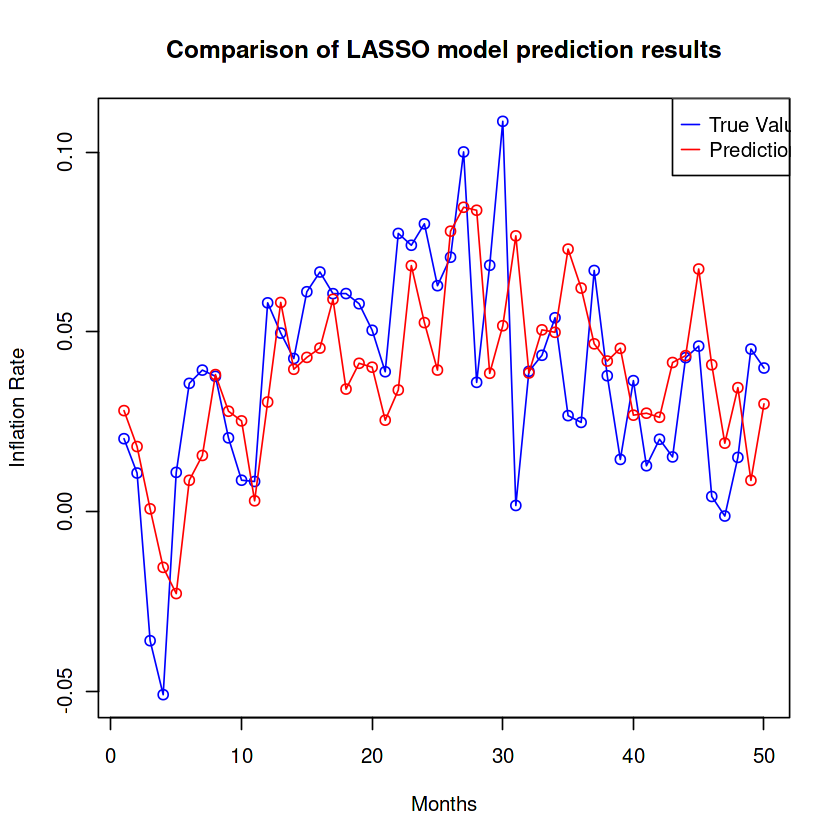

In [38]:
#在新数据中验证lasso
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优模型进行预测
predictions <- predict(best_lasso_model, s = best_lambda, newx = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse <- mean((Y_test_sub - predictions)^2)
print(paste("均方误差为:", mse))


## The closer the available data is to the prediction date the better the model predictions will be.